In [54]:
from selenium.common.exceptions import NoSuchElementException
from selenium import webdriver
import time, random, requests, io, os, sys
from pydub import AudioSegment
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.common.keys import Keys
import speech_recognition as sr
from os import path
from selenium.common.exceptions import TimeoutException
from word2number import w2n
import jellyfish
import matplotlib.pyplot as plt
import numpy as np
import wave
import math
import contextlib


In [55]:
class CaptchaBreaker:
    
    """
    __init__: Class Constructor
    Args:
        tc: Test Cases Count.
    Returns:
        None        
    """
    def __init__(self, tc):
        
        # Setting Default Download Directory For Chrome Automation
        chromeOptions = webdriver.ChromeOptions()
        prefs = {"download.default_directory" : "C:/Users/Sarim Balkhi/Documents/Captcha"}
        chromeOptions.add_experimental_option("prefs",prefs)
        
        # Declaring Class Variables
        self.driver = webdriver.Chrome(chrome_options=chromeOptions)
        self.downloads_folder = ""
        self.test_cases = tc
        self.results_ibm = []
        self.results_google = []
        
        # Class/ID For HTML ELEMENTS         
        self.audio_challenge_btn_class = "audioBtn"
        self.audio_download_btn_id = "audio_download"
        self.result_text_area_class = "response_field"
        self.submit_result_btn_id = "audio_submit"
        self.result_role = "alert"

        
    """
    visit_website: Visits the website 
    Args:
        website: URL of website whose captcha has to be bypassed.
    Returns:
        None        
    """
    def visit_website(self, website):
        self.driver.get(website)
        time.sleep(5)
        
        
    """
    load_captcha: Load captcha challenge and switch iframe 
    Args:
        None
    Returns:
        None        
    """
    def load_captcha(self):
        print("Loading Captcha Challenge")
        iframes = self.driver.find_elements_by_tag_name("iframe")
        time.sleep(0.5)
        self.driver.switch_to_frame(iframes[0])
        time.sleep(1)
        
        
    """
    download_audio: Clicks on download audio button and save it in the current working directory 
    Args:
        None
    Returns:
        None
    """
    def download_audio(self):
        print("Downloading Challenge Audio")
        time.sleep(1)
        self.driver.find_element_by_xpath('//*[@class="'+self.audio_challenge_btn_class+'"]').click()
        time.sleep(1)
        self.driver.find_element_by_xpath('//*[@id="'+self.audio_download_btn_id+'"]').click()


    """
    soundex_mapping: Map the word to a number (0-9) based on its soundex. E.g For->4, on->1 
    Args:
        word: (string) Word to be mapped
    Returns:
        num: integer (0-9)
    """
    def soundex_mapping(self, word):
        print("Performinig Soundex Mapping")
        sounds = {"Z600":0,"O500":1,"T000":2,"T600":3,"F600":4,"F100":5,"S200":6,"S150":7,"E230":8,"N500":9}
        try:
            num = sounds[jellyfish.soundex(word)]
        except:
            num = 0
        return num
    

    """
    transcribe: 
        Loads an audio file
        Transcribe it using Google's & IBM's Speech to text APIs
        Apply Soundex mapping if necessary
        Delete audio file
    Args:
        audio_file: (string) Name of audio file to be transcribed
        google: (int) 1 if transcription using google else 0
        ibm: (int) 1 if transcription using ibm else 0
    Returns:
        result: (string) Transcribed audio result
    """
    def transcribe(self, audio_file, google=0, ibm=0):
        print("Transcribing")
        r = sr.Recognizer()
        with sr.AudioFile(audio_file) as source:
            audio = r.record(source)  

            
        result = ""    

        # Recognize using Google's Text to Speech
        if google==1:
            try:
                result = r.recognize_google(audio)
                result = str(result).split(" ")
                for i in range(len(result)):
                    if(result[i].isdigit() == False):
                        try:
                            result[i] = w2n.word_to_num(result[i])
                        except:
                            result[i] = self.soundex_mapping(result[i])
                result = ''.join(str(n) for n in result)
                print("[Google Transcription] " + result)
            except sr.UnknownValueError:
                print("Google Speech Recognition could not understand audio")
            except sr.RequestError as e:
                print("Could not request results from Google Speech Recognition service; {0}".format(e))

                
        # recognize speech using IBM Speech to Text
        if ibm==1:
            IBM_USERNAME = "b3ea3fd8-ec09-4129-9545-1c021d3b29bb"  # IBM Speech to Text username
            IBM_PASSWORD = "0TGG83NgIeYp"  # IBM Speech to Text passwords
            try:
                result = r.recognize_ibm(audio, username=IBM_USERNAME, password=IBM_PASSWORD)
                result = result.split(" ")
                result = [n.replace("\n","") for n in result if len(n)>1]
                result = [str(self.soundex_mapping(n)) for n in result]
                result = ''.join(str(n) for n in result)
                print("[IBM Transcription] " + result)
            except sr.UnknownValueError:
                print("IBM Speech to Text could not understand audio")
            except sr.RequestError as e:
                print("Could not request results from IBM Speech to Text service; {0}".format(e))

        os.remove(audio_file)
        return result
 

    """
    get_audio_file: Gets the name of audio file in current directory
    Args:
        None
    Returns:
        audio: (string) Name of audio file in current directory
    """
    def get_audio_file(self):
        audio = ""
        for file in os.listdir():
            if file.endswith(".wav"):
                audio = os.path.join(file)
        return audio
    
    
    

    """
    From: https://stackoverflow.com/questions/24920346/filtering-a-wav-file-using-python
    audio_noise_removal: 
        Remove noise from an audio file by wavelength filtering.
        Deletes original file.
        Save new file with reduced noise.
    Args:
        fname: (string) name of audio file to be processed
    Returns:
        None
    """
    def audio_noise_removal(self, fname):
        print("Removing Noise")
        outname = 'filtered.wav'

        cutOffFrequency = 1400.0

        """
        from http://stackoverflow.com/questions/13728392/moving-average-or-running-mean
        running_mean: Moving Average
        Args:
            x: channel
            windowSize: Size of window
        Returns:

        """
        def running_mean(x, windowSize):
          cumsum = np.cumsum(np.insert(x, 0, 0)) 
          return (cumsum[windowSize:] - cumsum[:-windowSize]) / windowSize

        
        """
        From: http://stackoverflow.com/questions/2226853/interpreting-wav-data/2227174#2227174
        interpret_wav: Extract Raw Audio from multi-channel Wav File
        Args:
            raw_bytes: Bytes of wav file
            n_frames: Frames of wav file
            n_channels: Channels of wav file
            interleaved: Is interleaved (0/1)
        Returns:

        """
        def interpret_wav(raw_bytes, n_frames, n_channels, sample_width, interleaved = True):

            if sample_width == 1:
                dtype = np.uint8 # unsigned char
            elif sample_width == 2:
                dtype = np.int16 # signed 2-byte short
            else:
                raise ValueError("Only supports 8 and 16 bit audio formats.")

            channels = np.fromstring(raw_bytes, dtype=dtype)

            if interleaved:
                # channels are interleaved, i.e. sample N of channel M follows sample N of channel M-1 in raw data
                channels.shape = (n_frames, n_channels)
                channels = channels.T
            else:
                # channels are not interleaved. All samples from channel M occur before all samples from channel M-1
                channels.shape = (n_channels, n_frames)

            return channels

        with contextlib.closing(wave.open(fname,'rb')) as spf:
            sampleRate = spf.getframerate()
            ampWidth = spf.getsampwidth()
            nChannels = spf.getnchannels()
            nFrames = spf.getnframes()

            # Extract Raw Audio from multi-channel Wav File
            signal = spf.readframes(nFrames*nChannels)
            spf.close()
            channels = interpret_wav(signal, nFrames, nChannels, ampWidth, True)

            # get window size
            # from http://dsp.stackexchange.com/questions/9966/what-is-the-cut-off-frequency-of-a-moving-average-filter
            freqRatio = (cutOffFrequency/sampleRate)
            N = int(math.sqrt(0.196196 + freqRatio**2)/freqRatio)

            # Use moviung average (only on first channel)
            filtered = running_mean(channels[0], N).astype(channels.dtype)

            wav_file = wave.open(outname, "w")
            wav_file.setparams((1, ampWidth, sampleRate, nFrames, spf.getcomptype(), spf.getcompname()))
            wav_file.writeframes(filtered.tobytes('C'))
            wav_file.close()
            
            os.remove(fname)

    
    
            
    """
    attempt_captcha: Put the calculated answers in the textbox of captcha and submit it
    Args:
        text: (string) The calculated result of captcha
    Returns:
        integer: (0-1) 1 if captcha bypassed successfully else 0
    """        
    def attempt_captcha(self, text):
        print("Attempting Captcha")
        self.driver.find_element_by_xpath('//*[@class="'+self.result_text_area_class+'"]').send_keys(text)
        time.sleep(2)
        self.driver.find_element_by_xpath('//*[@id="'+self.submit_result_btn_id+'"]').click()
        time.sleep(2)
        alert = self.driver.find_element_by_xpath('//*[@role="'+self.result_role+'"]').text
        

        if "Incorrect" in alert:
            print("Bypass Failed\n")
            return 0
        else:
            print("Bypass SuccessFull\n")
            return 1
    
    
    

    """
    refresh_browser: Refresh browser
    Args:
        None
    Returns:
        None
    """
    def refresh_browser(self):
        time.sleep(1)
        self.driver.refresh()
        time.sleep(25)
    
    

    """
    jarvis_break_captcha: 
        Loads Captcha
        Download Audio Challenge
        Remove Noise From Audio
        Transcribe Audio
        Attempt Captcha
        Store Results
        Refresh Browser (If running batch validations)
    Args:
        google: (int) 1 if transcription using google else 0
        ibm: (int) 1 if transcription using ibm else 0
        batch: (int) 1 if validating in batch else 0
    Returns:
        None
    """
    def jarvis_break_captcha(self, ibm=0, google=0, batch=0):
        
        if batch == 1:
            
            print("\n\nBypassing With IBM Speech To Text Service\n\n")
            for i in range(0,self.test_cases):
                try:
                    self.load_captcha()
                    self.download_audio()                
                    time.sleep(3)            
                    self.audio_noise_removal(self.get_audio_file())
                    self.results_ibm.append(self.attempt_captcha(self.transcribe(self.get_audio_file(), ibm=1, google=0)))
                    self.refresh_browser()
                except Exception as e:
                    print("[Error!] ", e)
                  
                
            print("\n\nBypassing With GOOGLE Speech To Text Service\n\n")
            for i in range(0,self.test_cases):
                try:
                    self.load_captcha()
                    self.download_audio()
                    time.sleep(3)            
                    self.audio_noise_removal(self.get_audio_file())
                    self.results_google.append(self.attempt_captcha(self.transcribe(self.get_audio_file(), ibm=0, google=1)))
                    self.refresh_browser()
                except Exception as e:
                    print("[Error!] ", e)
                    
            
            self.generate_results()
            
        
        else:
            try:
                self.load_captcha()
                self.download_audio()
                time.sleep(3)            
                self.audio_noise_removal(self.get_audio_file())
                self.attempt_captcha(self.transcribe(self.get_audio_file(), ibm=ibm, google=google))
                self.refresh_browser()
            except Exception as e:
                print("[Error!] ", e)
            

    
    
    """
    generate_results: Generate Reuslts and visuals (Stacked Bargraphs)
    Args:
        None
    Returns:
        None
    """
    def generate_results(self):
        month=["IBM","GOOGLE"]
        n=len(month)
        
        ibm_per = ( self.results_ibm.count(1) / self.test_cases) * 100
        google_per = ( self.results_google.count(1) / self.test_cases) * 100
        
        right=np.array([ibm_per,google_per])
        wrong=np.array([100 - ibm_per, 100 - google_per])

        ind=np.arange(n)
        width=0.35

        p1=plt.bar(ind,right,width,color='#b5ffb9', edgecolor='white',)
        p2=plt.bar(ind,wrong,width,color='#f9bc86', edgecolor='white',bottom=right)

        plt.ylabel("Bypass Successfull (Green)")
        plt.title("Bypass Failed (Red)")
        plt.xticks(ind+width/2,("IBM","GOOGLE"))
        plt.show()
        
        
        



Bypassing With IBM Speech To Text Service


Loading Captcha Challenge
Removing Noise
Transcribing


C:\Users\Sarim Balkhi\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:220: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


Performinig Soundex Mapping
Performinig Soundex Mapping
Performinig Soundex Mapping
Performinig Soundex Mapping
Performinig Soundex Mapping
Performinig Soundex Mapping
Performinig Soundex Mapping
[IBM Transcription] 6586352
Attempting Captcha
Bypass SuccessFull

Loading Captcha Challenge
Removing Noise
Transcribing
Performinig Soundex Mapping
Performinig Soundex Mapping
Performinig Soundex Mapping
Performinig Soundex Mapping
Performinig Soundex Mapping
Performinig Soundex Mapping
[IBM Transcription] 459851
Attempting Captcha
Bypass SuccessFull

Loading Captcha Challenge
Removing Noise
Transcribing
Performinig Soundex Mapping
Performinig Soundex Mapping
Performinig Soundex Mapping
Performinig Soundex Mapping
Performinig Soundex Mapping
Performinig Soundex Mapping
[IBM Transcription] 040498
Attempting Captcha
Bypass Failed

Loading Captcha Challenge
Removing Noise
Transcribing
Performinig Soundex Mapping
Performinig Soundex Mapping
Performinig Soundex Mapping
Performinig Soundex Mapping


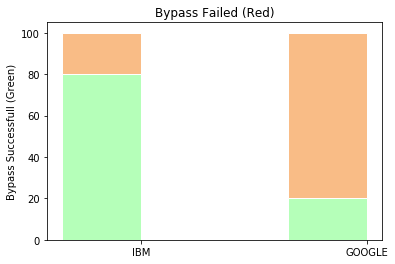

In [56]:
# Creating Object of CaptchaBreaker with 10 test cases
c = CaptchaBreaker(10)

# Visiting Website
c.visit_website("https://www.funcaptcha.com/demo")

# Perform Batch Analysis
c.jarvis_break_captcha(batch=1)


In [37]:
# Perform Single Analysis
# c.jarvis_break_captcha(batch=0, google=1)